In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:


df = pd.read_csv('/content/drive/MyDrive/spam.csv') #write your own file path
df.head()



,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape


(5572, 2)

In [7]:
print("Null values in each column:\n", df.isnull().sum())

print("\nAny null values? ->", df.isnull().values.any())

df[df.isnull().any(axis=1)]


Null values in each column:
 Category    0
Message     0
dtype: int64

Any null values? -> False


,Category,Message


In [8]:
#find duplicates and drop (inplace=True)
print("Duplicate rows:", df.duplicated().sum())

# 🔹 Drop duplicate rows (inplace=True will modify df directly)
df.drop_duplicates(inplace=True)

# 🔹 Check again
print("After removing duplicates:", df.duplicated().sum())
print("New shape:", df.shape)


Duplicate rows: 415
After removing duplicates: 0
New shape: (5157, 2)


In [9]:
#now it should be false
df.duplicated().any()


np.False_

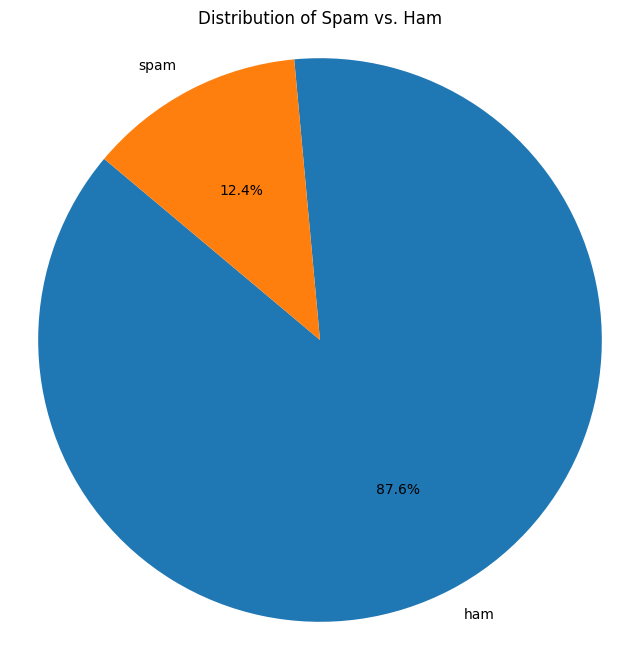

In [10]:
# Calculate the count of each label
category_counts = df['Category'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#TEXT VISUALIZATION

- Iterate through unique categories: This loop iterates through each unique category in the 'Category' column of the DataFrame df.¶
- Filter the DataFrame for the current category: Inside the loop, the code filters the DataFrame df to create a new DataFrame filtered_df containing only the rows where the 'Category' column matches the current category.
- Concatenate all text data for the current category: The code then concatenates all the text data from the 'Message' column of filtered_df into a single string variable named text.
- Generate word cloud: Using the concatenated text data (text), the code generates a word cloud using the WordCloud module. The word cloud is configured to have a width of 800 pixels, a height of 400 pixels, and a white background.
- Plot the word cloud: Finally, the code plots the generated word cloud using Matplotlib. Each word's size in the word cloud is proportional to its frequency in the concatenated text data. The title of each word cloud plot includes the current category being processed. The plt.axis('off') command is used to hide the axes of the plot.
This process repeats for each unique category, generating a separate word cloud for each category based on the text data associated with that category.

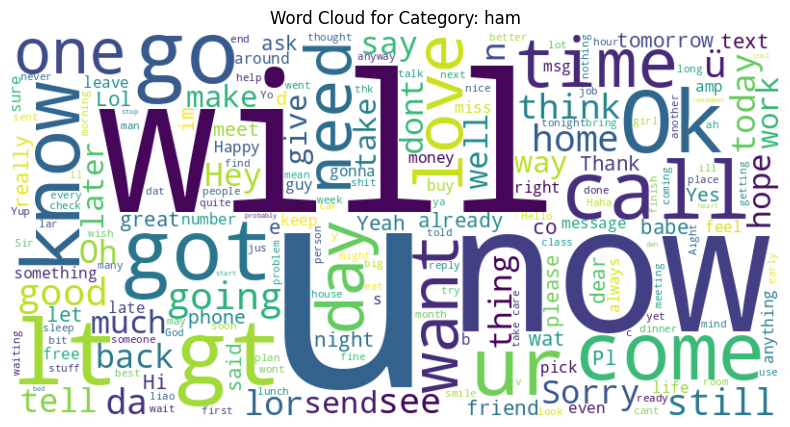

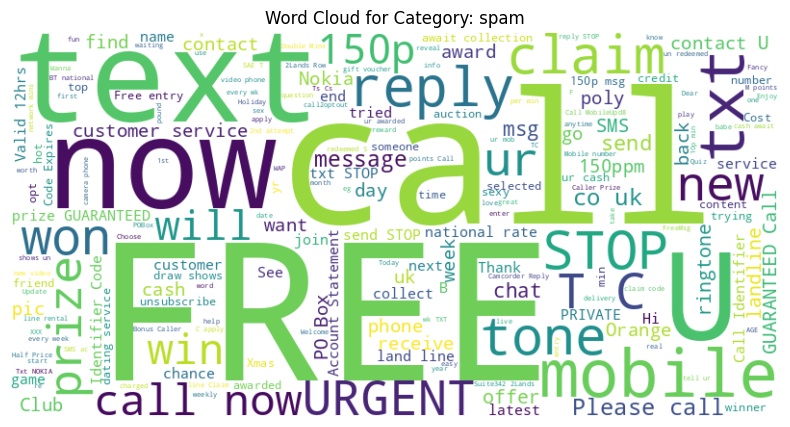

In [11]:
# Iterate through unique categories
for category in df['Category'].unique():
    # Filter the DataFrame for the current category
    filtered_df = df[df['Category'] == category]

    # Concatenate all text data for the current category
    text = ' '.join(filtered_df['Message'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

In [12]:
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#Text Preprocessing

1. Lower Casing¶
2. Remove Extra White Spaces
3. Remove HTML Tags
4. Remove URLs
5. Remove Punctuations
6. Remove Special Characters
7. Remove Numeric Values
8. Remove Non-alpha Numeric

10. Handling StopWords¶
11. Handling Emojis
12. Stemming



In [13]:
# Convert 'Text' column to lowercase
df['Message'] = df['Message'].str.lower()

# Check few rows
df.head()

,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [14]:


# Remove extra white spaces from the 'Text' column

df['Message'] = df['Message'].str.strip()        # remove leading/trailing spaces
df['Message'] = df['Message'].replace(' ', regex=True)  # replace multiple spaces with single space

# Check few rows
df.head()




,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [15]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    if text is None:
        return None
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove HTML tags from 'Text' column
df['Message'] = df['Message'].apply(remove_html_tags)

In [16]:
# Define a function to remove URLs using regular expressions
def remove_urls(text):
    if text is None:
        return None
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Apply the function to the 'Text' column
df['Message'] = df['Message'].apply(remove_urls)

In [17]:
def remove_special_characters(text):
    if text is None:
        return None
    # Define the pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'
    return re.sub(pattern, '', text)

# Apply the function to the 'Message' column
df['Message'] = df['Message'].apply(remove_special_characters)

In [18]:
# Function to remove numeric values from text
def remove_numeric(text):
    if text is None:
        return None
    return re.sub(r'\d+', '', text)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(remove_numeric)

In [19]:
# Define a function to remove non-alphanumeric characters
def remove_non_alphanumeric(text):
    if text is None:
        return None
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(remove_non_alphanumeric)

In [20]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [21]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    if text is None:
        return None
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

# Apply replace_chat_words function to 'Text' column
df['Message'] = df['Message'].apply(replace_chat_words)

In [22]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    if not isinstance(text, str):
        return text # Return non-string inputs as is
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Message'] = df['Message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# Function to remove emojis from text
def remove_emojis(text):
    if text is None:
        return None
    return emoji.demojize(text)

# Apply remove_emojis function to 'Text' column
df['Message'] = df['Message'].apply(remove_emojis)

In [24]:
# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

# Apply stemming
df['Message_stemmed'] = df['Message'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]) if isinstance(x, str) else x)
df.head()

,Category,Message,Message_stemmed
0,0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,0,ok lar joking wif oni,ok lar joke wif oni
2,1,free entry wkly comp win fa cup final tkts st ...,free entri wkli comp win fa cup final tkt st m...
3,0,dun say early hor c already say,dun say earli hor c alreadi say
4,0,nah dont think goes usf lives around though,nah dont think goe usf live around though


In [25]:
#Convert text to numbers using bag of words
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']


In [26]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

#Solve this problem using Logistic Regression(using numpy from scratch)

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer






In [28]:

df = pd.read_csv('/content/drive/MyDrive/spam.csv')


le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])


df['Message'] = df['Message'].str.lower()

# Split dataset
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Message'], df['Category'], test_size=0.2, random_state=42
)


In [29]:
# Using simple Bag-of-Words
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

# Convert labels to numpy arrays
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


In [30]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Loss function (Binary Cross-Entropy)
def compute_loss(y, y_hat):
    m = y.shape[0]
    return -(1/m) * np.sum(y*np.log(y_hat + 1e-8) + (1-y)*np.log(1 - y_hat + 1e-8))

# Gradient Descent
def logistic_regression(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    W = np.zeros((n, 1))  # weights
    b = 0                  # bias

    for i in range(epochs):
        # Linear model
        Z = np.dot(X, W) + b
        y_hat = sigmoid(Z)

        # Gradients
        dW = (1/m) * np.dot(X.T, (y_hat - y))
        db = (1/m) * np.sum(y_hat - y)

        # Update parameters
        W -= lr * dW
        b -= lr * db

        if i % 100 == 0:
            loss = compute_loss(y, y_hat)
            print(f'Epoch {i}, Loss: {loss:.4f}')

    return W, b

# Prediction
def predict(X, W, b):
    y_hat = sigmoid(np.dot(X, W) + b)
    return (y_hat >= 0.5).astype(int)


In [31]:
W, b = logistic_regression(X_train, y_train, lr=0.1, epochs=1000)


Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2965
Epoch 200, Loss: 0.2224
Epoch 300, Loss: 0.1847
Epoch 400, Loss: 0.1615
Epoch 500, Loss: 0.1455
Epoch 600, Loss: 0.1337
Epoch 700, Loss: 0.1246
Epoch 800, Loss: 0.1172
Epoch 900, Loss: 0.1111


In [32]:
y_pred = predict(X_test, W, b)
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.967713004484305


#Now Use sklearn library to fit the data using logistic regression and compare results

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


def evaluate_sklearn(X_train, X_test, y_train, y_test, vec_name, reg_strength=1.0):
    # LogisticRegression(C=1/λ) --> smaller C = stronger regularization
    model = LogisticRegression(C=reg_strength, max_iter=500, solver="lbfgs")
    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== sklearn Results ({vec_name}, C={reg_strength}) =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, prec, rec, f1

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


results = []

vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=2000),
    "TfidfVectorizer": TfidfVectorizer(max_features=2000)
}

for vec_name, vectorizer in vectorizers.items():
    # Feature extraction
    X = vectorizer.fit_transform(df['Message']).toarray()
    y = df['Category'].values.reshape(-1, 1)

    # Feature scaling
    scaler = StandardScaler(with_mean=False)
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Baseline (default C=1.0)
    acc, prec, rec, f1 = evaluate_sklearn(X_train, X_test, y_train, y_test, vec_name, reg_strength=1.0)
    results.append([vec_name, "C=1.0", acc, prec, rec, f1])

    # Try stronger/weaker regularization
    for C in [0.1, 10]:
        acc, prec, rec, f1 = evaluate_sklearn(X_train, X_test, y_train, y_test, vec_name, reg_strength=C)
        results.append([vec_name, f"C={C}", acc, prec, rec, f1])


===== sklearn Results (CountVectorizer, C=1.0) =====
Accuracy: 0.9865
Precision: 0.9786
Recall: 0.9195
F1-score: 0.9481
Confusion Matrix:
 [[963   3]
 [ 12 137]]

===== sklearn Results (CountVectorizer, C=0.1) =====
Accuracy: 0.9857
Precision: 0.9784
Recall: 0.9128
F1-score: 0.9444
Confusion Matrix:
 [[963   3]
 [ 13 136]]

===== sklearn Results (CountVectorizer, C=10) =====
Accuracy: 0.9821
Precision: 0.9388
Recall: 0.9262
F1-score: 0.9324
Confusion Matrix:
 [[957   9]
 [ 11 138]]

===== sklearn Results (TfidfVectorizer, C=1.0) =====
Accuracy: 0.9874
Precision: 0.9720
Recall: 0.9329
F1-score: 0.9521
Confusion Matrix:
 [[962   4]
 [ 10 139]]

===== sklearn Results (TfidfVectorizer, C=0.1) =====
Accuracy: 0.9883
Precision: 0.9928
Recall: 0.9195
F1-score: 0.9547
Confusion Matrix:
 [[965   1]
 [ 12 137]]

===== sklearn Results (TfidfVectorizer, C=10) =====
Accuracy: 0.9812
Precision: 0.9156
Recall: 0.9463
F1-score: 0.9307
Confusion Matrix:
 [[953  13]
 [  8 141]]


In [37]:
import pandas as pd

results_df = pd.DataFrame(results, columns=["Vectorizer", "Regularization", "Accuracy", "Precision", "Recall", "F1"])
print("\n===== sklearn Logistic Regression Results Summary =====\n")
print(results_df)


===== sklearn Logistic Regression Results Summary =====

        Vectorizer Regularization  Accuracy  Precision    Recall        F1
0  CountVectorizer          C=1.0  0.986547   0.978571  0.919463  0.948097
1  CountVectorizer          C=0.1  0.985650   0.978417  0.912752  0.944444
2  CountVectorizer           C=10  0.982063   0.938776  0.926174  0.932432
3  TfidfVectorizer          C=1.0  0.987444   0.972028  0.932886  0.952055
4  TfidfVectorizer          C=0.1  0.988341   0.992754  0.919463  0.954704
5  TfidfVectorizer           C=10  0.981166   0.915584  0.946309  0.930693
